### Setup

In [1]:
# installing
!pip install datasets
!pip install transformers
#!pip install hydra-core
#!pip install fairseq

     |████████████████████████████████| 194kB 7.8MB/s 
     |████████████████████████████████| 245kB 13.3MB/s 
     |████████████████████████████████| 112kB 15.6MB/s 
     |████████████████████████████████| 1.9MB 9.1MB/s 
     |████████████████████████████████| 3.2MB 51.7MB/s 
     |████████████████████████████████| 890kB 54.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=97c0265cdbacff5c9ec3686fee4af18981c66bf1fdda4cc6c4b3d45c005aa22a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
# load packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data import random_split

import torch.nn as nn
import torch.nn.functional as F

import librosa as lb

In [3]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data

#### Data Analysis

In [ ]:
# pre-processing (frequency filtering necessary?)
# data loader (any augmentation techniques in NLP?)
# https://www.machinecurve.com/index.php/2021/02/17/easy-speech-recognition-with-machine-learning-and-huggingface-transformers/

In [5]:
# load one recording
# audio processing: https://librosa.org/doc/main/generated/librosa.load.html
waveform, rate = lb.load('drive/MyDrive/Colab Notebooks/data/clips/1a7b4c57ea08555e6c968cbcc8875ecf70b3df42207e9556d71f1fd40b3de915d0bae21d9fe740aa56b32ad7b3dea958168bb3a84d583b3c6d46c5d2a7c5bcbe.mp3', sr = 16000)

print(waveform)
print(waveform.shape)
print(max(waveform))
print(min(waveform))

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[ 1.8193451e-07 -1.6756445e-07  1.4029875e-07 ...  1.0064449e-04
 -7.5070961e-06  4.1764350e-05]
(45696,)
0.27622885
-0.28632727


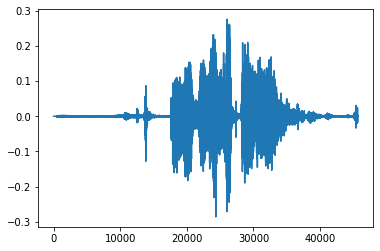

In [ ]:
# plot waveform
plt.figure()
plt.plot(waveform)
plt.show()

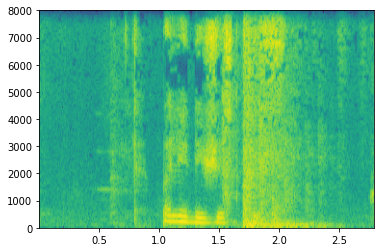

In [ ]:
# plot power spectrum density
plt.figure()
plt.specgram(waveform[1000:], Fs=16000, mode='psd', scale='dB')
plt.show()

#### Data Loader

In [ ]:
# check out dataframe
df = pd.read_csv('drive/MyDrive/Colab Notebooks/data/ASR_train.csv')
print(df.keys())
print(df.head(5))

Index(['ID', 'up_votes', 'down_votes', 'age', 'gender', 'transcription'], dtype='object')
                                                  ID  ...                  transcription
0  002e50c29ac2890c7cb3b3d63dcbe512bc6850de206ca8...  ...                        Malicka
1  0031672b4484f963c8a07babe6f713dd559539d44140e8...  ...  Ecole Elementaire Pikine Nord
2  00362ccc6b48d3ea225e12ddf8a06a9d582cccc03b0353...  ...         Cimetière de Cambérène
3  0042cdb4d4a015cddacc26d88faffdd714b7a27213d2b3...  ...                Tournalou Boune
4  00439f02fa8f0dade934bdb317199b71662e9396f6bb81...  ...             Pharmacie Golf Sud

[5 rows x 6 columns]
002e50c29ac2890c7cb3b3d63dcbe512bc6850de206ca80477704628fb1194de25fb31484fd3ef7ec27efbe87524a8d325c9e7e08d5b1e9f2b0ca2a19fe12089


In [11]:
# suppress annoying warnings while reading audio files
import warnings
warnings.filterwarnings('ignore')

In [12]:
## read into memory (small) -> storing takes around 2hrs
## IMPORTANT: it's not persisted across sessions (why not?)
import os.path
import pandas as pd

if os.path.isfile('drive/MyDrive/Colab Notebooks/data/ASR_train_audio.ft'):
    print ("File exist")
    df = pd.read_feather('drive/MyDrive/Colab Notebooks/data/ASR_train_audio.ft')
else:
    print("File does not exist")

    # initialize with list
    audio_signals = len(df['ID'])*[[0]]
    df['audio_signal'] = audio_signals

    # functional but not elegant (nor fast probably)
    for k in range(100): # len(df)
      id = df.iloc[k]['ID']
      path = os.path.join('drive/MyDrive/Colab Notebooks/data/clips/', id+'.mp3')
      waveform, rate = lb.load(path, sr = 16000)
      df.at[k, 'audio_signal'] = waveform

      if k % 100 == 0:
        print('file '+ str(k))

    # store as faster feather format
    df[:100].to_feather('drive/MyDrive/Colab Notebooks/data/ASR_train_audio.ft')


File does not exist
file 0


In [24]:
# not anymore needed if above code snippet works as expected
df2 = pd.read_feather('drive/MyDrive/Colab Notebooks/data/ASR_train_audio.ft')

In [ ]:
# NOT REQUIRED for now (but for later if we want to do dataset augmentation)
class dataloader(Dataset):
    """ Hateful Memes dataset """
    
    def __init__(self, data, audio_dir):
        """
        Args:
            data: pandas file with (ID, up_votes, down_votes, age, gender, transcription)
            audio_dir: direction to audio files
        """
        # text
        self.data = data
        
        # audio
        self.audio_dir = audio_dir
        
    def __len__(self):
        return len(self.data['ID'])
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx_tolist()
        
        # load audio ------------------------------------
        audio_name = os.path.join(self.audio_dir, str(self.data['ID'][idx]))
        image = cv2.imread(img_name)
        
        # transcription ---------------------------------
        label = self.data['labels'][idx]
        label = np.array([label])
        label = label.astype('int').reshape(-1)
        
        # token? -------------------------------------------
        token = self.data['tokens'][idx]
        
        # prepare token ids: each token (word fragment) corresponds to an id in the bert corpus
        # further need to make all review the same length -> padding too short, truncating too long ones
        token_id = pad_sequences([tokenizer.convert_tokens_to_ids(token)], maxlen=token_length, truncating="post", padding="post", dtype="int")
        token_id = token_id.reshape(-1)
        
        #
        sample = {'image': image, 'token_id': token_id, 'mask': mask, 'label': label}
            
        return sample

### Model

#### Wav2vec2

In [ ]:
## 
from transformers import Wav2Vec2Tokenizer, Wav2Vec2ForCTC # https://huggingface.co/facebook/wav2vec2-large-960h
from datasets import load_dataset # https://github.com/huggingface/datasets
import soundfile as sf
import torch

# load model and tokenizer
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

#print(model.parameters)

# define function to read in sound file
def map_to_array(batch):
    speech, _ = sf.read(batch["file"])
    batch["speech"] = speech
    return batch

# load dummy dataset and read soundfiles
ds = load_dataset("patrickvonplaten/librispeech_asr_dummy", "clean", split="validation")
ds = ds.map(map_to_array)

# tokenize
input_values = tokenizer(ds["speech"][:2], return_tensors="pt", padding="longest").input_values  # Batch size 1

# retrieve logits
logits = model(input_values).logits

# take argmax and decode
predicted_ids = torch.argmax(logits, dim=-1)
transcription = tokenizer.batch_decode(predicted_ids)

Reusing dataset librispeech_asr (/root/.cache/huggingface/datasets/librispeech_asr/clean/2.1.0/468ec03677f46a8714ac6b5b64dba02d246a228d92cbbad7f3dc190fa039eab1)
Loading cached processed dataset at /root/.cache/huggingface/datasets/librispeech_asr/clean/2.1.0/468ec03677f46a8714ac6b5b64dba02d246a228d92cbbad7f3dc190fa039eab1/cache-99e95014b26a2688.arrow


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

for p in model.parameters():
           p.requires_grad = False

print(count_parameters(model))

315460768
0


#### XLSR Model Transformers

In [16]:
## imports
from transformers import Wav2Vec2Tokenizer, Wav2Vec2ForCTC # https://huggingface.co/facebook/
from datasets import load_dataset
import soundfile as sf
from itertools import groupby

# model and tokenizer (warnings can be neglected?)
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-large-xlsr-53-french")
modelWav2Vec2 = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-xlsr-53-french")

Some weights of the model checkpoint at facebook/wav2vec2-large-xlsr-53-french were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.masked_spec_embed']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
## helpers 
def map_to_array(batch):
    speech, _ = sf.read(batch["file"])
    batch["speech"] = speech
    return batch

In [48]:
## processing
idx = 2

# tokenize
input_values = tokenizer(list(df2[idx:idx+1]['audio_signal'].values[0]), return_tensors="pt", padding="longest").input_values  # Batch size 

# retrieve logits
logits = modelWav2Vec2(input_values).logits

predicted_ids = torch.argmax(logits, axis=-1)

transcription = tokenizer.batch_decode(predicted_ids)
print('XLSR: ' + str(transcription[0]))
print('Ground truth: '+ str(df2[idx:idx+1]['transcription'].values[0]))

XLSR: simitier de camberen
Ground truth: Cimetière de Cambérène


#### XLSR Model Fairseq

In [ ]:
# install directly from Github. installing it from pip leads to dependency issues
%cd "/content/drive/My Drive/Colab Notebooks/"
!git clone https://github.com/pytorch/fairseq
%cd fairseq
!pip install --editable .

/content/drive/My Drive/Colab Notebooks
fatal: destination path 'fairseq' already exists and is not an empty directory.
/content/drive/My Drive/Colab Notebooks/fairseq
Obtaining file:///content/drive/My%20Drive/Colab%20Notebooks/fairseq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Found existing installation: fairseq 1.0.0a0+d031611
    Can't uninstall 'fairseq'. No files were found to uninstall.
  Running setup.py develop for fairseq


In [ ]:
# load model
import fairseq
model, cfg, task  = fairseq.checkpoint_utils.load_model_ensemble_and_task(
    ["../drive/My Drive/Colab Notebooks/model/xlsr_53_56k.pt"])
#/content/drive/My Drive/Colab Notebooks

# evaluation mode
model = model[0]
model.eval()

In [ ]:
# https://colab.research.google.com/drive/1ljU1AfzMQkcMsS2VdR3AIMMHD5NwFhHV?usp=sharing#scrollTo=loFnGT4v4kxf
# https://huggingface.co/facebook/wav2vec2-large-xlsr-53-french

# keep for now but not of use at the moment
import torch
from datasets import load_dataset
import soundfile as sf
from itertools import groupby

libri_dummy = load_dataset(
    "patrickvonplaten/librispeech_asr_dummy", "clean", split="validation")


def map_to_array(batch):
    speech_array, _ = sf.read(batch["file"])
    batch["speech"] = speech_array
    return batch


class Decoder:
    def __init__(self, json_dict):
        self.dict = json_dict
        self.look_up = np.asarray(list(self.dict.keys()))

    def decode(self, ids):
        converted_tokens = self.look_up[ids]
        fused_tokens = [tok[0] for tok in groupby(converted_tokens)]
        output = ' '.join(
            ''.join(''.join(fused_tokens).split("<s>")).split("|"))
        return output

libri_dummy = libri_dummy.map(map_to_array, remove_columns=["file"])

input_sample = torch.tensor(libri_dummy[0]["speech"])[None, :]

logits = model(source=input_sample, padding_mask=None)["encoder_out"]
#logits = model(source=input_sample)["cpc_logits"]
# print(logits)

predicted_ids = torch.argmax(logits[:, 0], axis=-1)
json_dict = {"<s>": 0, "<pad>": 1, "</s>": 2, "<unk>": 3, "|": 4, "E": 5, "T": 6, "A": 7, "O": 8, "N": 9, "I": 10, "H": 11, "S": 12, "R": 13, "D": 14,
             "L": 15, "U": 16, "M": 17, "W": 18, "C": 19, "F": 20, "G": 21, "Y": 22, "P": 23, "B": 24, "V": 25, "K": 26, "'": 27, "X": 28, "J": 29, "Q": 30, "Z": 31}

decoder = Decoder(json_dict=json_dict)
print("Prediction: ", decoder.decode(predicted_ids))

Dataset librispeech_asr downloaded and prepared to /root/.cache/huggingface/datasets/librispeech_asr/clean/2.1.0/468ec03677f46a8714ac6b5b64dba02d246a228d92cbbad7f3dc190fa039eab1. Subsequent calls will reuse this data.


KeyError: ignored

### Training

In [ ]:
# helper functions
# loss
# metric

In [ ]:
# train (fine-tuning)

In [ ]:
# validation

In [ ]:
# process

In [ ]:
# prediction